In [6]:
# Import Necessary Libraries
import numpy as np
import os, csv, json

from matplotlib import *
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

from sklearn import cluster
from scipy.spatial import distance
from sklearn.decomposition import PCA as sklearnPCA

import pandas as pd

#### Set up R Independence Test 
np.random.seed(12345678)  # for reproducibility, set random seed
from rpy2 import robjects
from rpy2.robjects import r

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [3]:
from pprint import pprint
# channel = ['Synap','Synap','VGlut1','VGlut1','VGlut2','Vglut3',
#            'psd','glur2','nmdar1','nr2b','gad','VGAT', 'PV','Gephyr',
#            'GABAR1','GABABR','CR1','5HT1A', 'NOS','TH','VACht',
#            'Synapo','tubuli','DAPI']

channel = ['Synap_01','Synap_02',
           'VGlut1_01','VGlut1_02',
           'VGlut2','Vglut3',
           'psd','glur2',
           'nmdar1','nr2b',
           'gad','VGAT', 
           'PV','Gephyr',
           'GABAR1','GABABR',
           'CR1','5HT1A', 
           'NOS','TH','VACht',
           'Synapo','tubuli','DAPI']

channeltype = ['ex.pre','ex.pre',
               'ex.pre','ex.pre',
               'ex.pre','in.pre.small', 
               'ex.post','ex.post',
               'ex.post','ex.post',
               'in.pre','in.pre', 
               'in.pre','in.post',
               'in.post','in.post',
               'in.pre.small','other',
               'ex.post','other','other',
               'ex.post','none','none']
print(channel)
print(channeltype)

['Synap_01', 'Synap_02', 'VGlut1_01', 'VGlut1_02', 'VGlut2', 'Vglut3', 'psd', 'glur2', 'nmdar1', 'nr2b', 'gad', 'VGAT', 'PV', 'Gephyr', 'GABAR1', 'GABABR', 'CR1', '5HT1A', 'NOS', 'TH', 'VACht', 'Synapo', 'tubuli', 'DAPI']
['ex.pre', 'ex.pre', 'ex.pre', 'ex.pre', 'ex.pre', 'in.pre.small', 'ex.post', 'ex.post', 'ex.post', 'ex.post', 'in.pre', 'in.pre', 'in.pre', 'in.post', 'in.post', 'in.post', 'in.pre.small', 'other', 'ex.post', 'other', 'other', 'ex.post', 'none', 'none']


In [54]:
channel_inhib_excit = ['ex.pre','ex.pre',
                       'ex.pre','ex.pre',
                       'ex.pre','in.pre.small', 
                       'ex.post','ex.post',
                       'ex.post','ex.post',
                       'in.pre','in.pre', 'in.pre',
                       'in.post','in.post','in.post']

# get only the channels with known excitatory and inhibitory
channeltype = np.array(channeltype)
# inhib_excit_indices = [idx for idx, x in enumerate(channeltype) if x in channel_inhib_excit]
inhib_excit_indices = np.arange(0, len(channel_inhib_excit))

channel = np.array(channel)
print "The column numbers of inhib/excit proteins: ", inhib_excit_indices
print "The channels used: ", channel[inhib_excit_indices]

print len(channel_inhib_excit)
print len(inhib_excit_indices)

The column numbers of inhib/excit proteins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
The channels used:  ['Synap_01' 'Synap_02' 'VGlut1_01' 'VGlut1_02' 'VGlut2' 'Vglut3' 'psd'
 'glur2' 'nmdar1' 'nr2b' 'gad' 'VGAT' 'PV' 'Gephyr' 'GABAR1' 'GABABR']
16
16


## Load in Data And Cluster And Evaluate
1. load in data
2. cluster using k-means 4, 5, 6
3. PCA into 2/3 dimensions and also make a Scree plot (up to n=6)
4. Compare cluster distributions of labels in 2/3 dimensions
5. compare the histogram distributions of excit/inhib values in each cluster

In [5]:
data = np.load('../../data/synapse_f0_features_log.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]
print 'data has shape: ', X.shape

# set options and then cluster
num_clusters = 4
colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#11111']
kmeans = cluster.MiniBatchKMeans(n_clusters = num_clusters, init="k-means++")
kmeans.fit(X)

# extract the data after fitting
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

print "Clustered With MiniBatchKmeans using ", num_clusters, " clusters"

data has shape:  (1119299, 19)
Clustered With MiniBatchKmeans using  4  clusters


[ 0.53820609  0.15999629  0.12858962  0.0510425   0.03970702  0.0296532
  0.01666353  0.01369476  0.00832028  0.00676787]
0.698202377292
0.826792001053


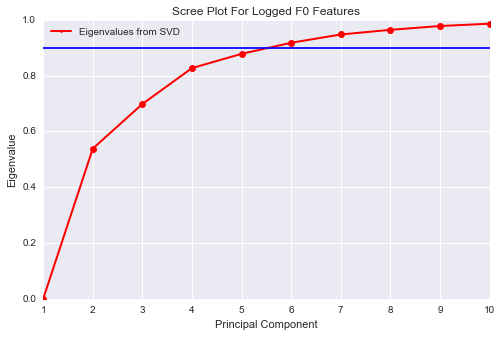

In [18]:
# first PCA on entire dataset, then get the rows
num_components = 10
sklearn_pca = sklearnPCA(n_components=num_components)
sklearn_transf = sklearn_pca.fit_transform(X)
sklearn_variance_explained = sklearn_pca.explained_variance_ratio_

# get the explained_ratio with number of components
sing_vals = np.arange(num_components) + 1
eig_vals_ratio = [sum(sklearn_variance_explained[0:i]) for i in range(0,len(sklearn_variance_explained))]

# plot scree plot
fig = plt.figure(figsize=(8,5))
plt.plot(sing_vals, eig_vals_ratio, 'ro-', linewidth=2)
plt.title('Scree Plot For Logged F0 Features')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.axhline(0.9)
leg = plt.legend(['Eigenvalues from PCA'], loc='best', borderpad=0.3, 
                 shadow=False, markerscale=0.4)

print sklearn_variance_explained
print sum(sklearn_variance_explained[0:2])
print sum(sklearn_variance_explained[0:3])

### Using PCA To Reduce Dimensionality
With PCA to reduce the dimensions down to 2 for each "synapse", it can capture ~70% of the data variance. 

Keeping that in mind while we analyze the cluster distributions With k=2, 4, 5, 6

number of components:  2
number of clusters:  2
For f0 features log transformed


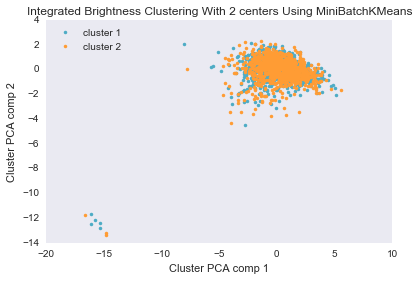

In [34]:
### First kmeans, then pca, then plot

print "number of components: ", num_components
print "number of clusters: ", num_clusters

## PCA
num_components = 2
sklearn_pca = sklearnPCA(n_components=num_components)
sklearn_transf = sklearn_pca.fit_transform(X)

colors = ['#4EACC5', '#FF9C34', '#4E9A06', 'black']


##### PLOT #####
fig = plt.figure()
ax = plt.gca()
for k, col in zip(range(num_clusters), colors):
    lab = 'cluster '+ str(k+1)
    
    my_members = k_means_labels == k # get indices of this current cluster membership
    cluster_center = k_means_cluster_centers[k] # get current cluster center
    
    rand_subset = np.random.choice(range(len(sklearn_transf[my_members,0])), size=1000, replace=False)
    ax.plot(sklearn_transf[rand_subset,0], sklearn_transf[rand_subset,1], 'wo', markerfacecolor=col, label=lab)

ax.grid(False)
ax.legend()
ax.set_xlabel('Cluster PCA comp 1')
ax.set_ylabel('Cluster PCA comp 2')
ax.set_title('Integrated Brightness Clustering With ' + str(num_clusters) + ' centers Using MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.tight_layout()

print "For f0 features log transformed"

## Now Do KMeans -> PCA -> Plot

number of components:  2
number of clusters:  2
For f0 features log transformed


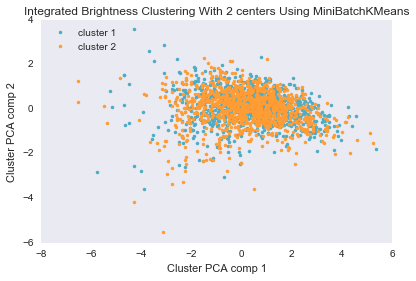

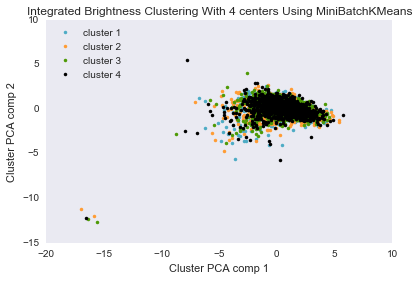

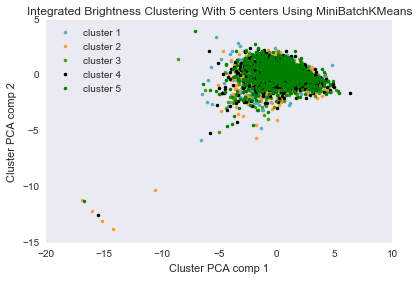

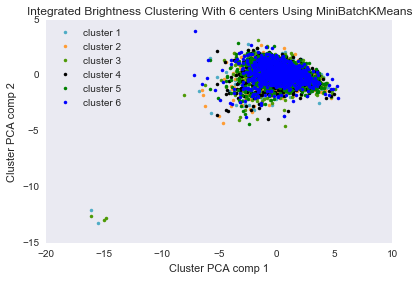

In [39]:
### First kmeans, then pca, then plot
print "number of components: ", num_components
print "number of clusters: ", num_clusters

num_clusters_list = [2, 4, 5, 6]
for i in range(0, len(num_clusters_list)):
    ## Kmeans
    # set options and then cluster
    num_clusters = num_clusters_list[i]
    colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#11111']
    kmeans = cluster.MiniBatchKMeans(n_clusters = num_clusters, init="k-means++")
    kmeans.fit(X)

    # extract the data after fitting
    k_means_labels = kmeans.labels_
    k_means_cluster_centers = kmeans.cluster_centers_
    k_means_labels_unique = np.unique(k_means_labels)

    ## PCA
    num_components = 2
    sklearn_pca = sklearnPCA(n_components=num_components)
    sklearn_transf = sklearn_pca.fit_transform(X)

    colors = ['#4EACC5', '#FF9C34', '#4E9A06', 'black', 'green', 'blue']

    ##### PLOT #####
    fig = plt.figure()
    ax = plt.gca()
    for k, col in zip(range(num_clusters), colors):
        lab = 'cluster '+ str(k+1)

        my_members = k_means_labels == k # get indices of this current cluster membership
        cluster_center = k_means_cluster_centers[k] # get current cluster center

        rand_subset = np.random.choice(range(len(sklearn_transf[my_members,0])), size=1000, replace=False)
        ax.plot(sklearn_transf[rand_subset,0], sklearn_transf[rand_subset,1], 'w.', markerfacecolor=col, label=lab)

    ax.grid(False)
    ax.legend(loc='upper left')
    ax.set_xlabel('Cluster PCA comp 1')
    ax.set_ylabel('Cluster PCA comp 2')
    ax.set_title('Integrated Brightness Clustering With ' + str(num_clusters) + ' centers Using MiniBatchKMeans')
    # ax.set_xticks(())
    # ax.set_yticks(())
    plt.tight_layout()

print "For f0 features log transformed"

## PCA -> KMeans -> Plot

 number of components:  2
number of clusters:  2
The shape of kmeans fit:  (2, 2)
For f0 features log transformed


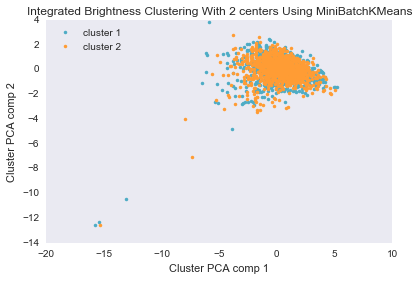

In [38]:
### First kmeans, then pca, then plot
print "number of components: ", num_components
print "number of clusters: ", num_clusters

## PCA
num_components = 2
sklearn_pca = sklearnPCA(n_components=num_components)
sklearn_transf = sklearn_pca.fit_transform(X)

## Kmeans
# set options and then cluster
num_clusters = 2
colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#11111']
kmeans = cluster.MiniBatchKMeans(n_clusters = num_clusters, init="k-means++")
kmeans.fit(sklearn_transf)

# extract the data after fitting
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)
print "The shape of kmeans fit: ", k_means_cluster_centers.shape

colors = ['#4EACC5', '#FF9C34', '#4E9A06', 'black']

##### PLOT #####
fig = plt.figure()
ax = plt.gca()
for k, col in zip(range(num_clusters), colors):
    lab = 'cluster '+ str(k+1)
    
    my_members = k_means_labels == k # get indices of this current cluster membership
    cluster_center = k_means_cluster_centers[k] # get current cluster center
    
    rand_subset = np.random.choice(range(len(sklearn_transf[my_members,0])), size=1000, replace=False)
    ax.plot(sklearn_transf[rand_subset,0], sklearn_transf[rand_subset,1], 'w.', markerfacecolor=col, label=lab)

ax.grid(False)
ax.legend(loc='upper left')
ax.set_xlabel('Cluster PCA comp 1')
ax.set_ylabel('Cluster PCA comp 2')
ax.set_title('Integrated Brightness Clustering With ' + str(num_clusters) + ' centers Using MiniBatchKMeans')
# ax.set_xticks(())
# ax.set_yticks(())
plt.tight_layout()

print "For f0 features log transformed"

### Cluster and Then Show Histograms of Each Protein's Expression

data has shape:  (1119299, 24)


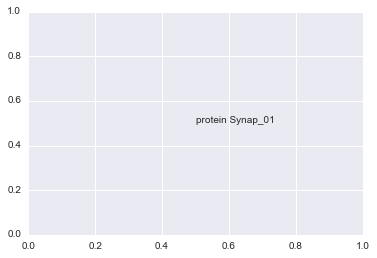

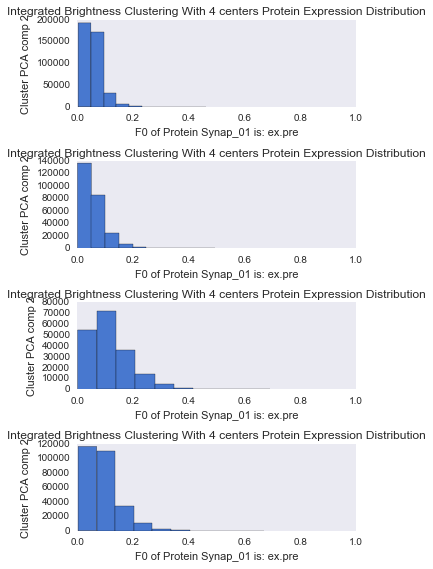

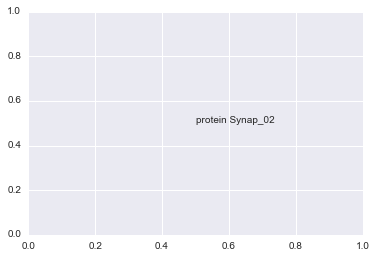

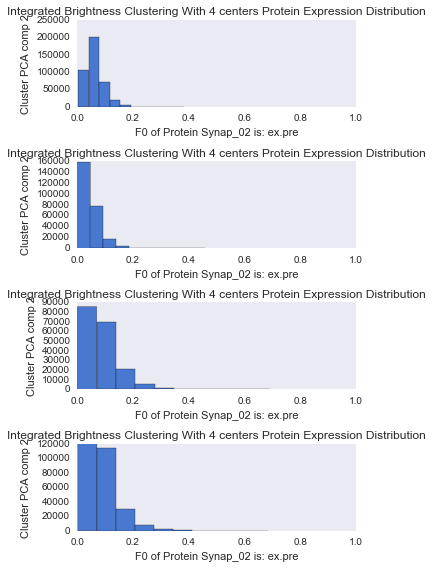

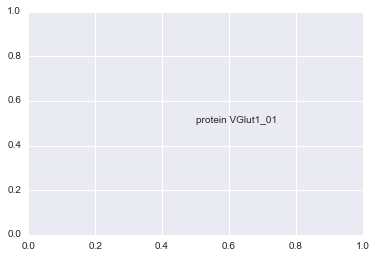

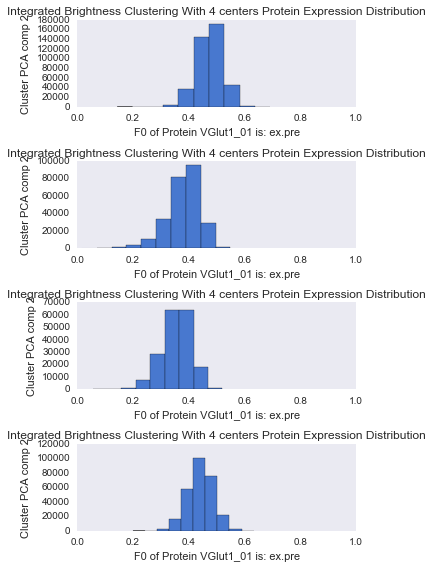

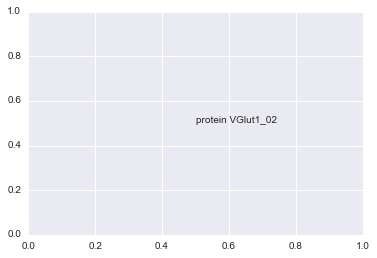

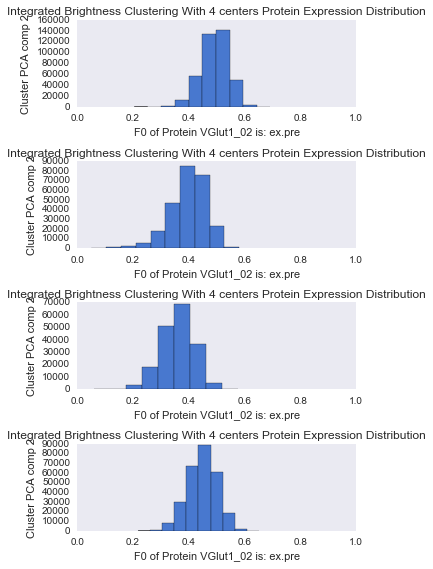

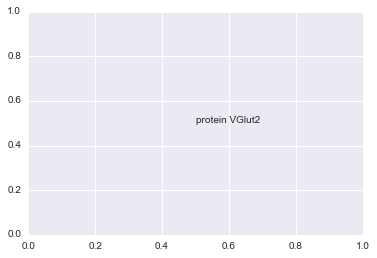

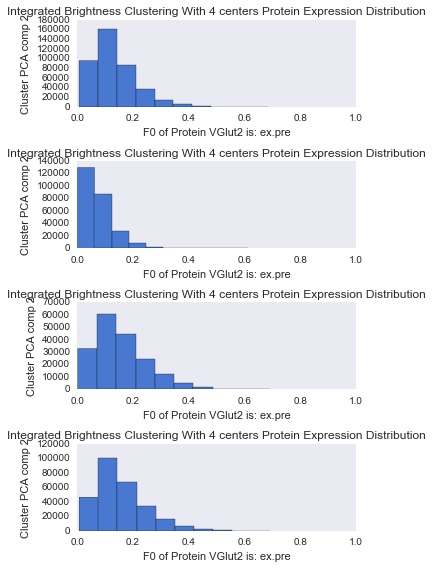

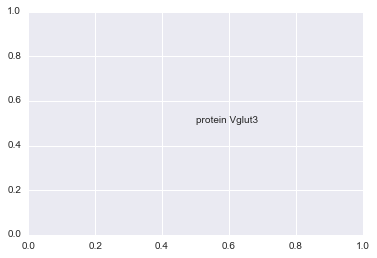

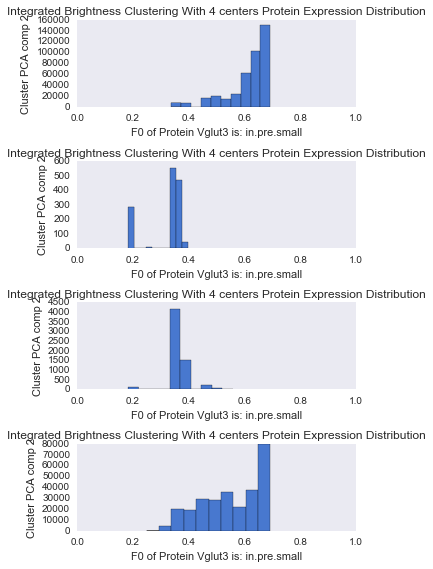

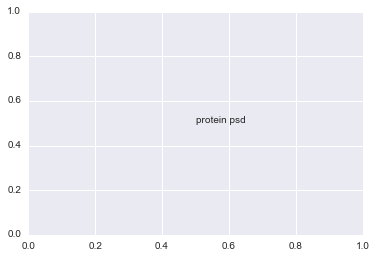

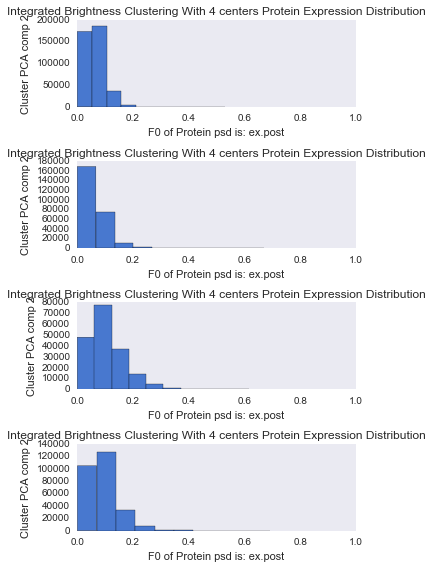

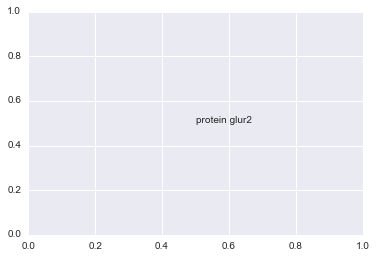

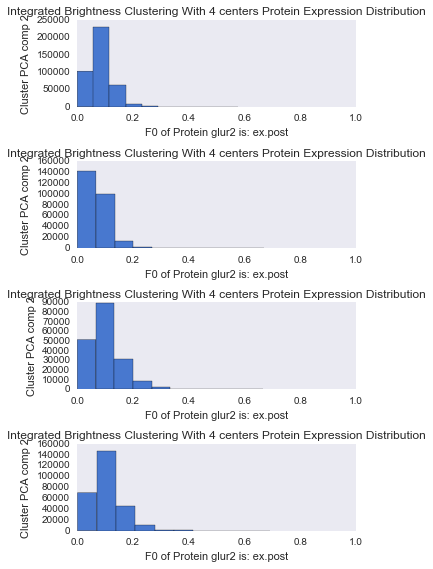

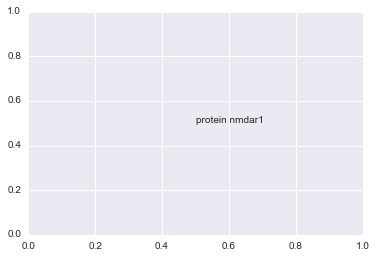

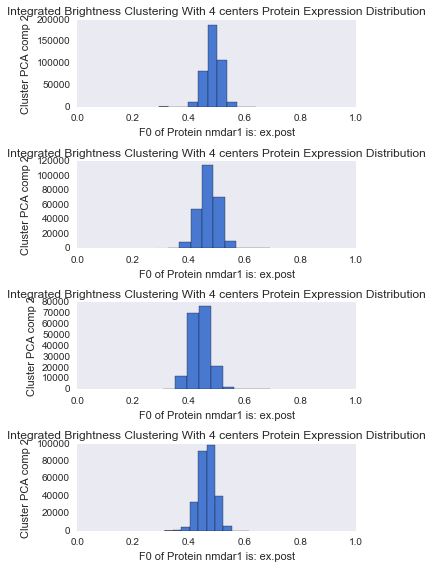

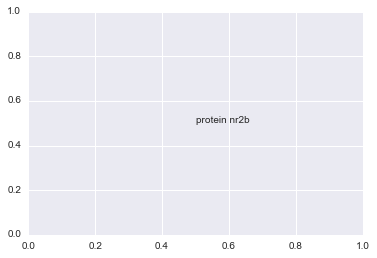

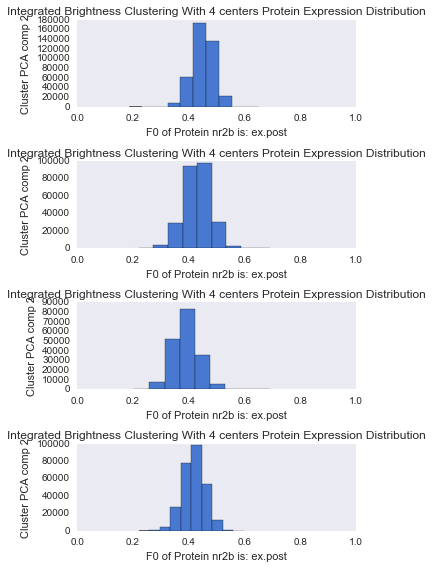

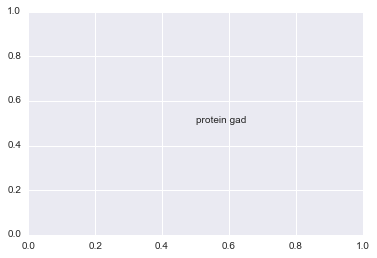

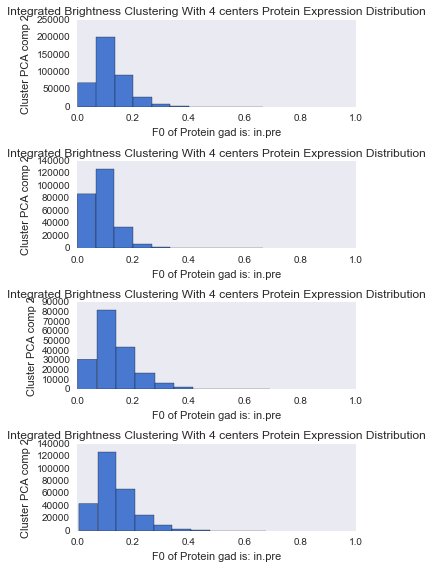

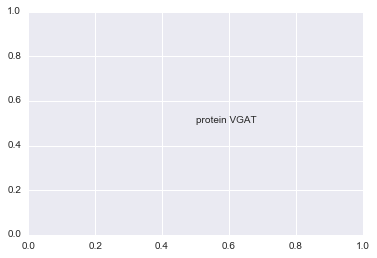

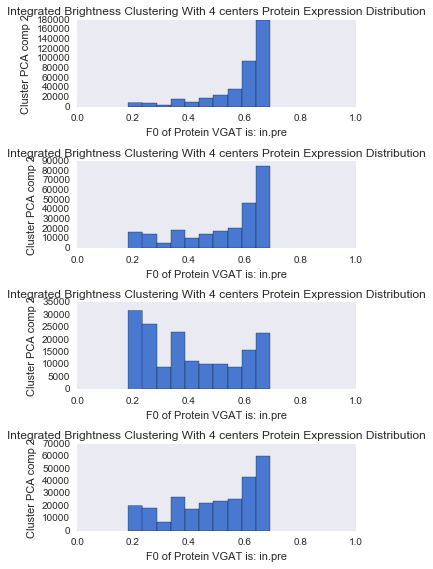

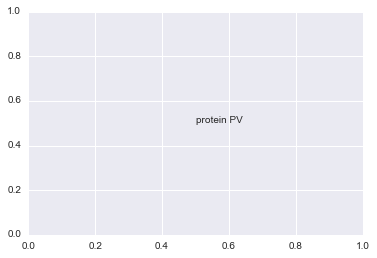

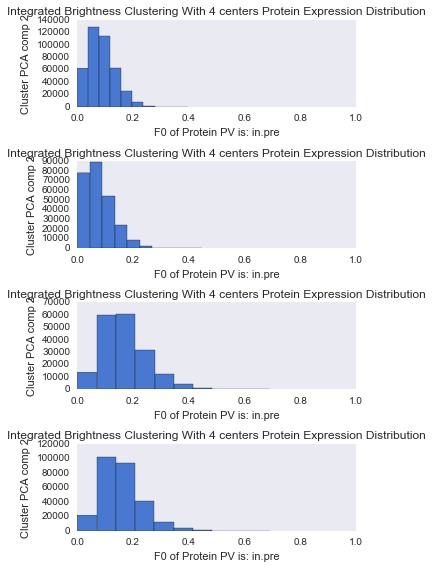

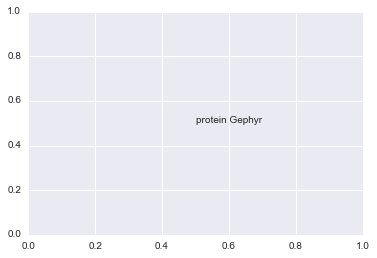

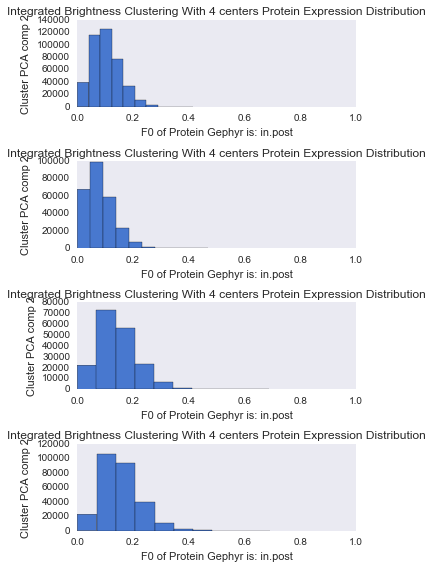

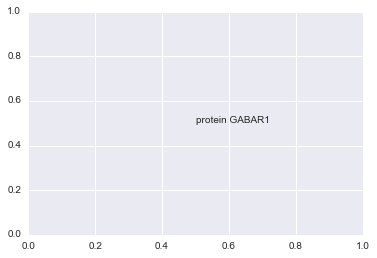

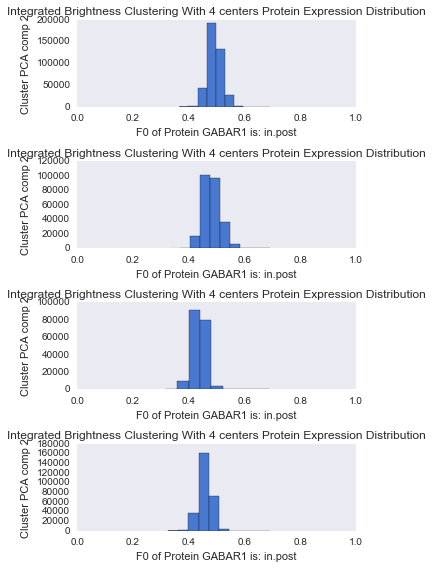

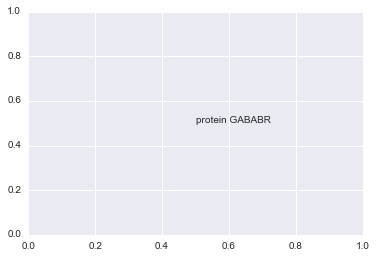

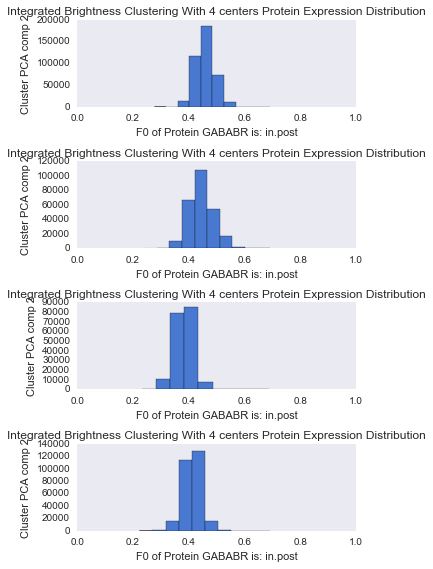

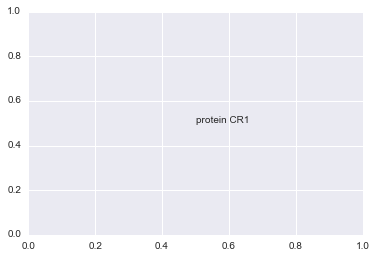

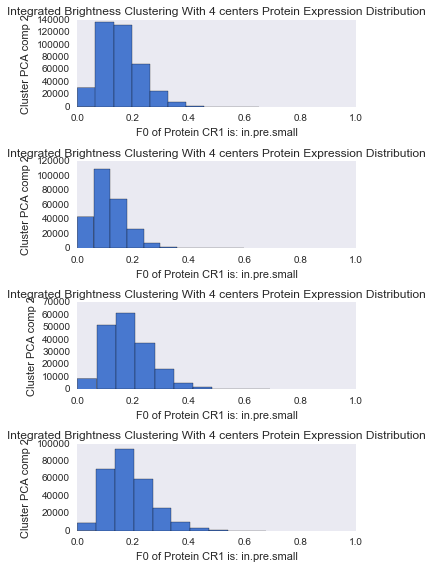

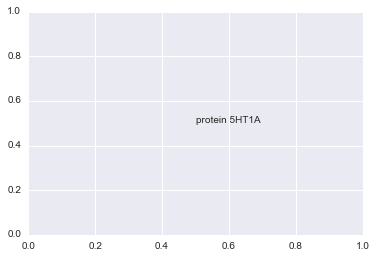

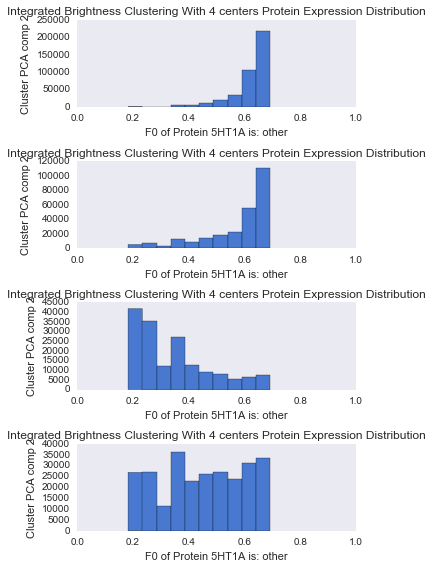

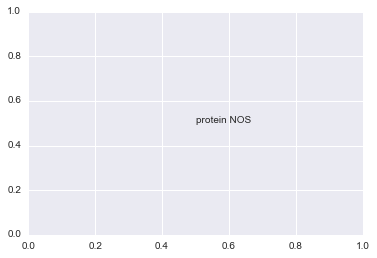

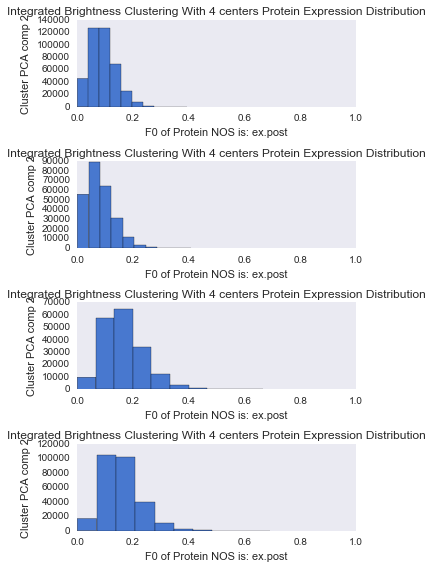

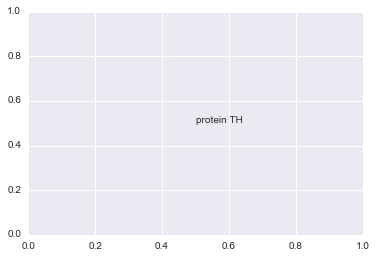

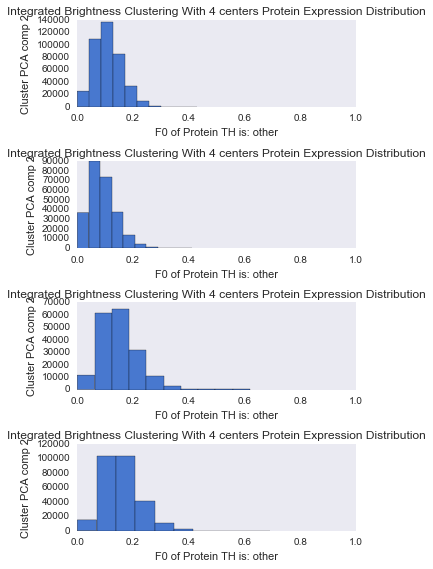

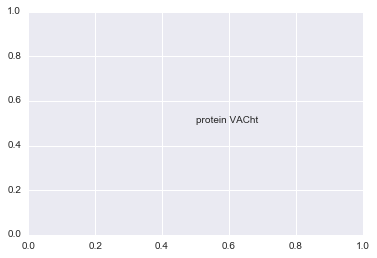

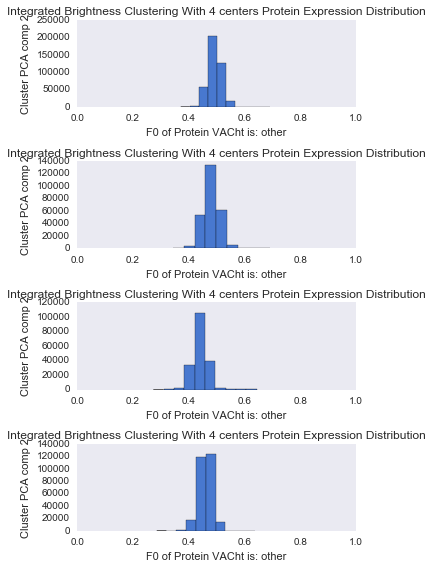

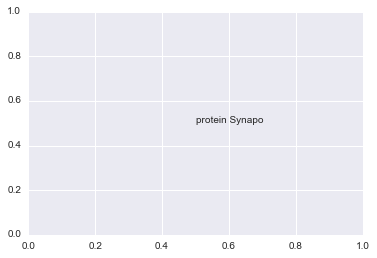

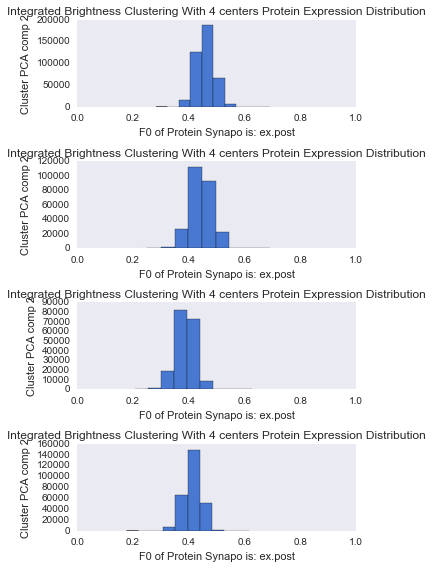

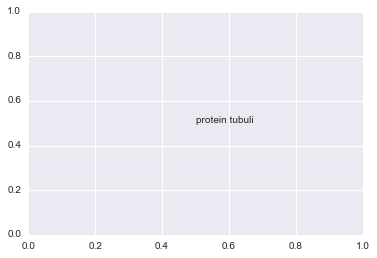

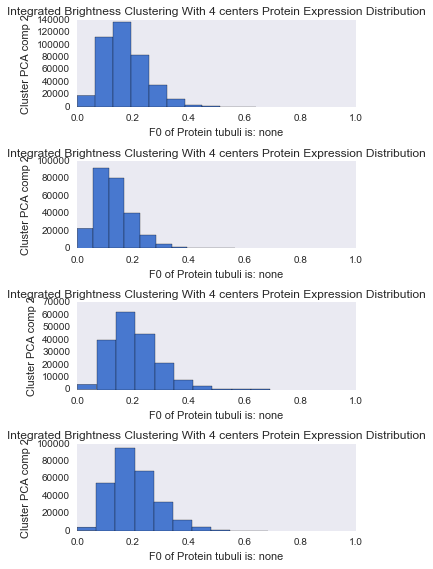

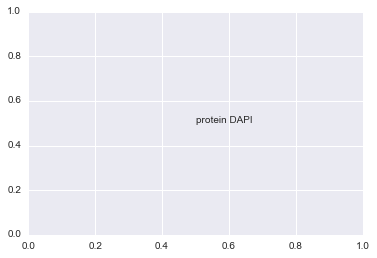

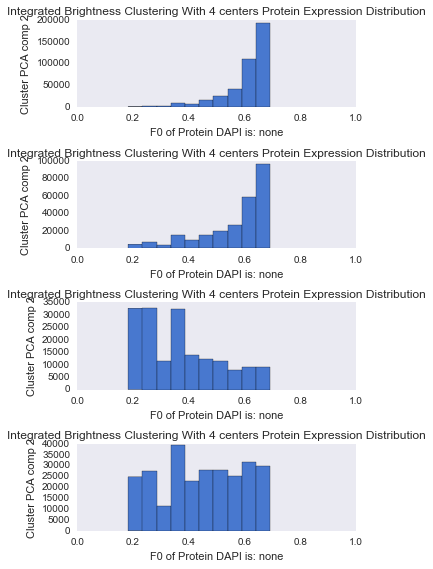

In [66]:
data = np.load('../../data/synapse_f0_features_log_normalized.npy')
X = data  # extract only the features
# X = X[:,inhib_excit_indices]
print 'data has shape: ', X.shape

# channel_inhib_excit = ['ex.pre','ex.pre','ex.pre','ex.pre','ex.pre','in.pre.small', 
#                'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre', 
#                'in.pre','in.post','in.post','in.post']

# set options and then cluster
num_clusters = 4
colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#11111', 'black', 'green', 'blue']
kmeans = cluster.MiniBatchKMeans(n_clusters = num_clusters, init="k-means++")
kmeans.fit(X)

# extract the data after fitting
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)


for i in range(0, len(channel)):#inhib_excit_indices)):
#     protein_to_plot = inhib_excit_indices[i]
    protein_to_plot = i
#     print protein_to_plot

    fig = plt.figure()
    plt.text(.5, .5, 'protein %s'%(channel[protein_to_plot]))

    
    ##### PLOT #####
    fig = plt.figure(figsize=(6,8))
    for k, col in zip(range(num_clusters), colors):
        ax = fig.add_subplot(num_clusters, 1, k+1)

    #     lab = 'cluster '+ str(k+1) # label for this distribution
        my_members = k_means_labels == k # get indices of this current cluster membership
        data = X[my_members,protein_to_plot]
        
        ## line to get rid of data with expression 0?
        data = data[data!=0]
        
        binwidth = 0.5
        ax.hist(data)
        ax.grid(False)
        ax.legend(loc='upper left')
        ax.set_xlabel('F0 of Protein ' + channel[protein_to_plot] + ' is: ' + channeltype[i])
        ax.set_ylabel('Cluster PCA comp 2')
        ax.set_xlim([0, 1.0])
        ax.set_title('Integrated Brightness Clustering With ' + str(num_clusters) + ' centers Protein Expression Distribution')
        plt.tight_layout()

## Dicsussion F0

Vglut3 separates visually for F0?

data has shape:  (1119299, 24)


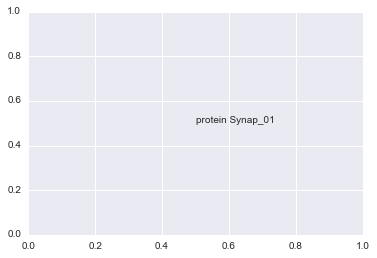

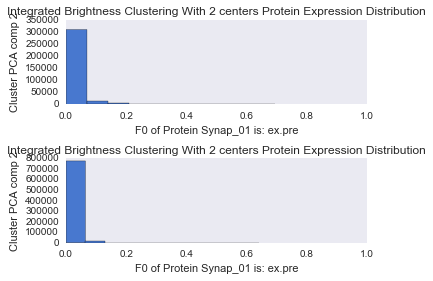

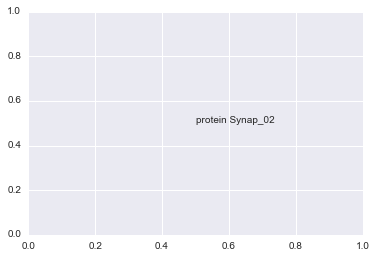

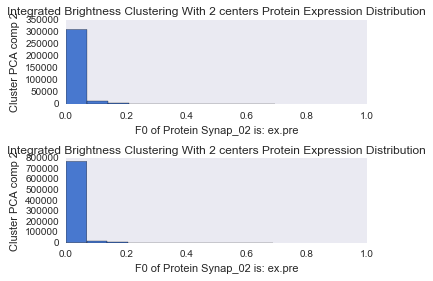

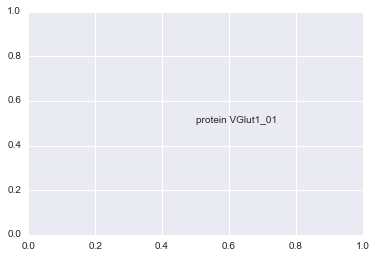

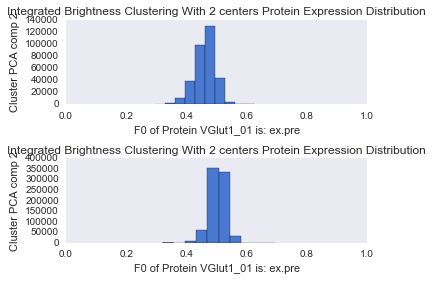

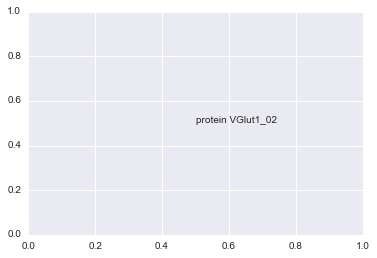

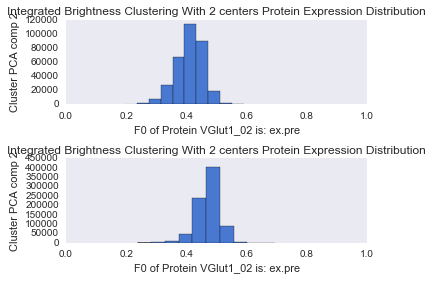

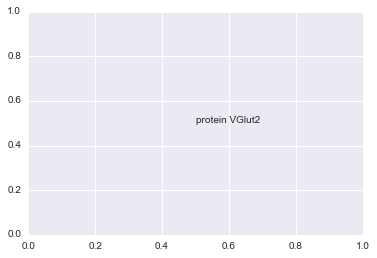

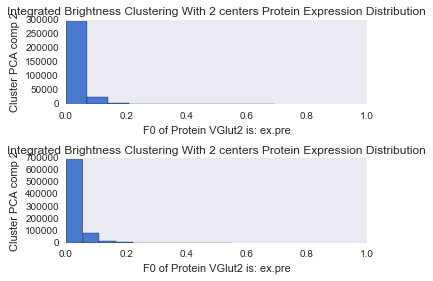

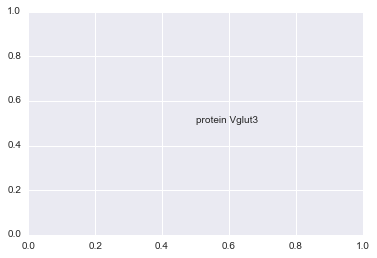

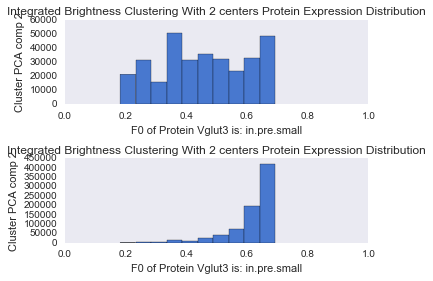

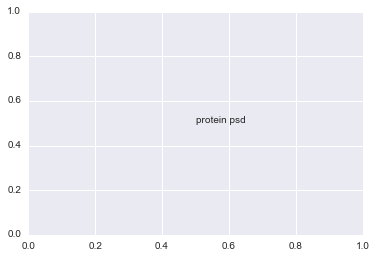

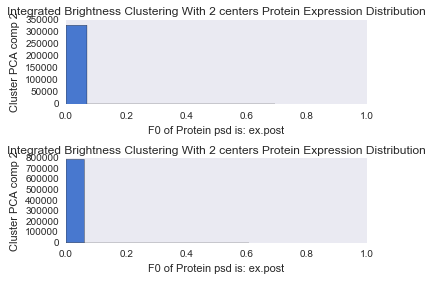

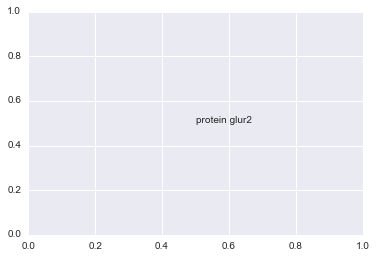

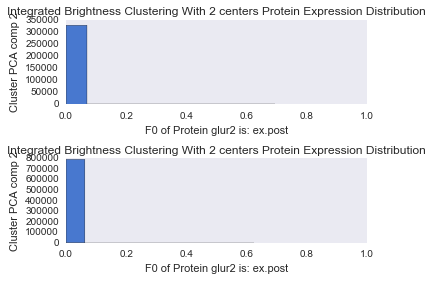

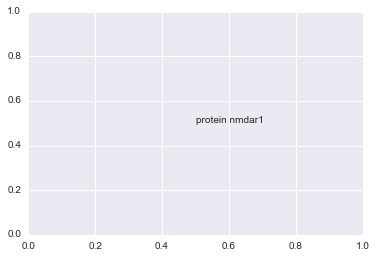

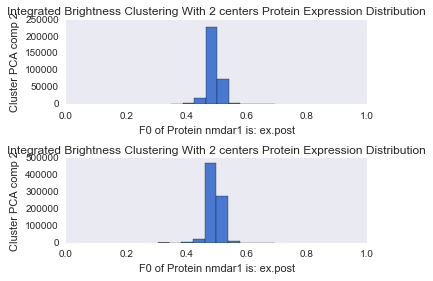

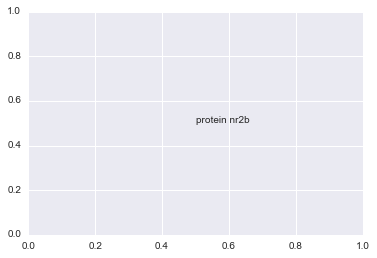

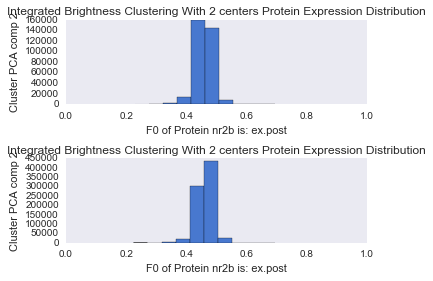

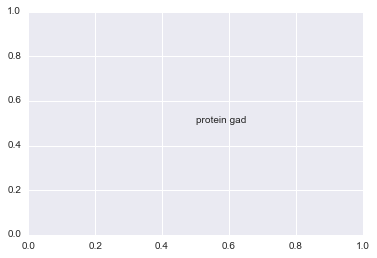

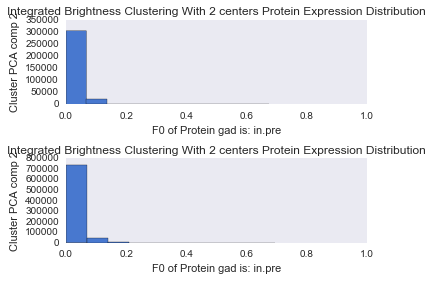

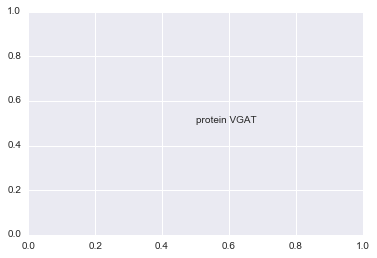

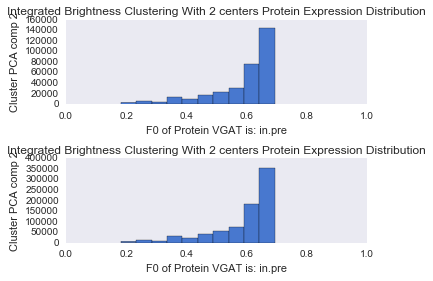

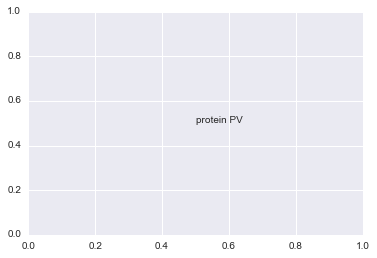

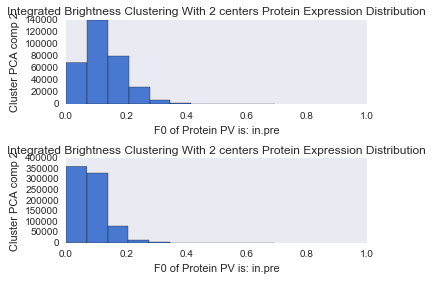

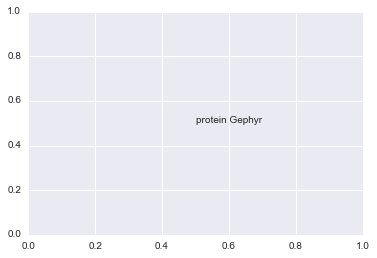

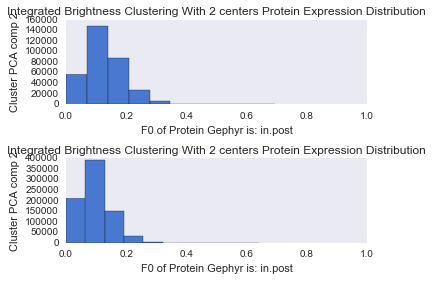

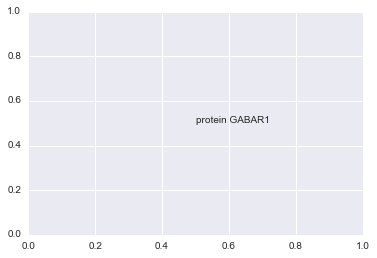

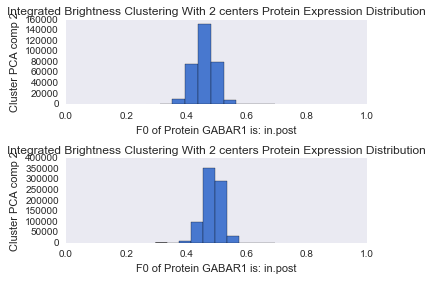

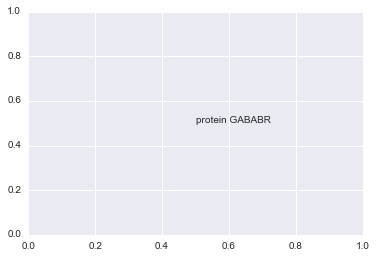

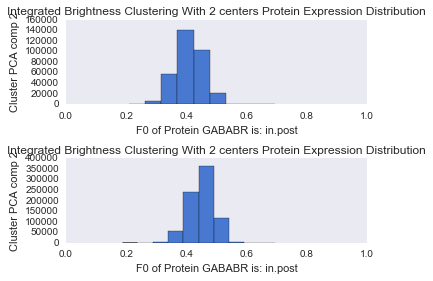

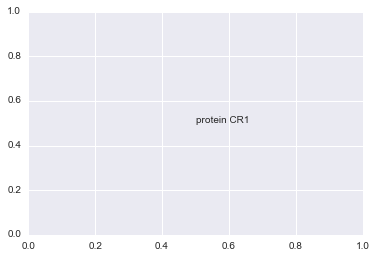

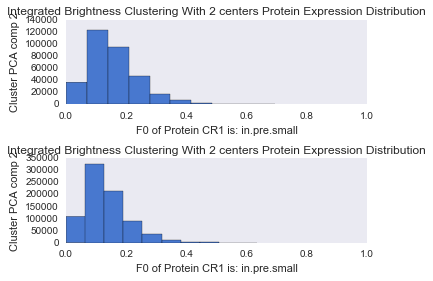

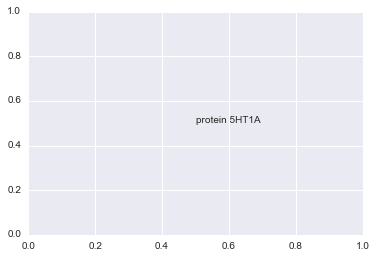

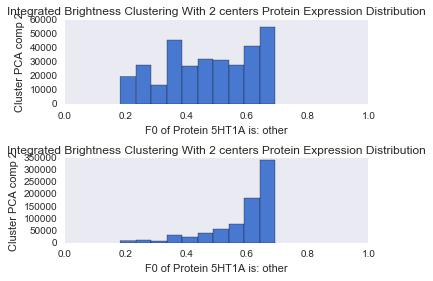

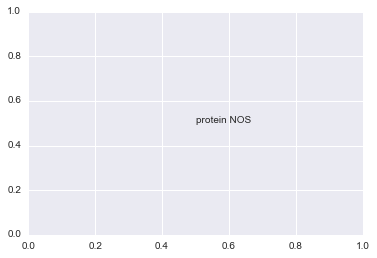

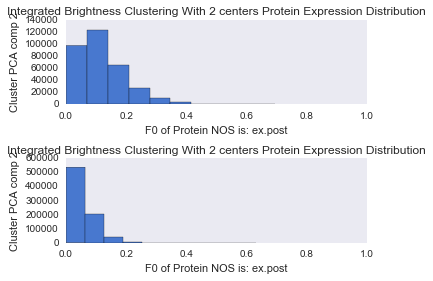

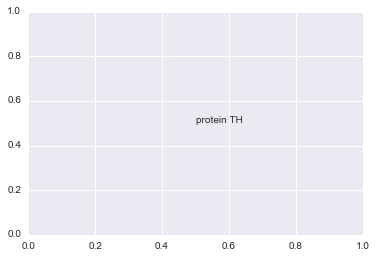

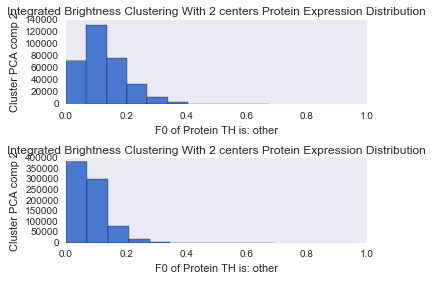

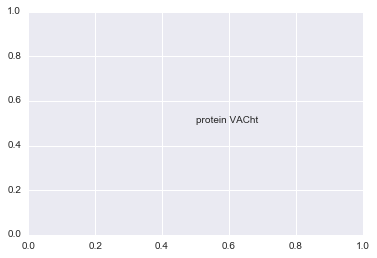

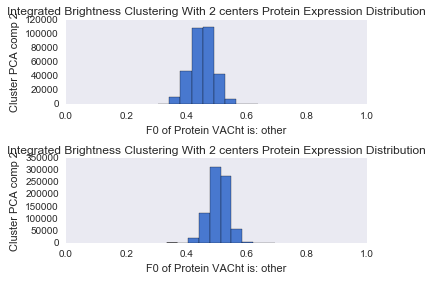

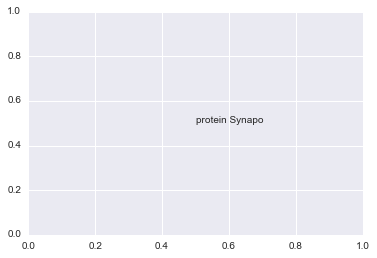

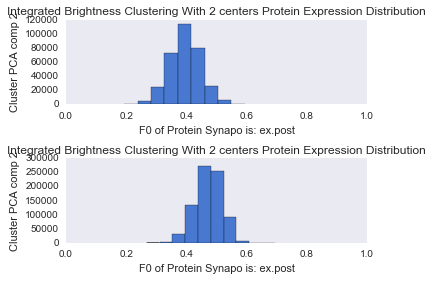

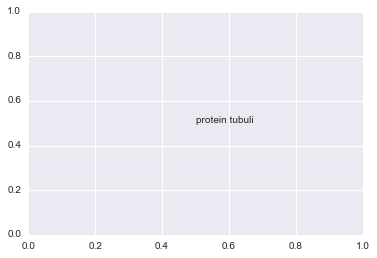

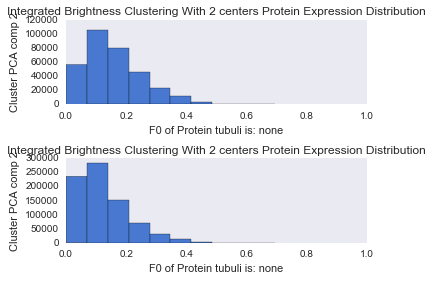

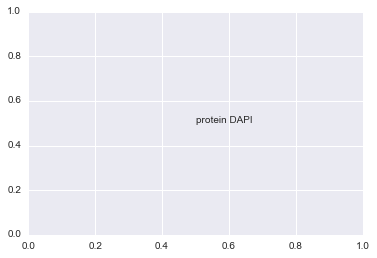

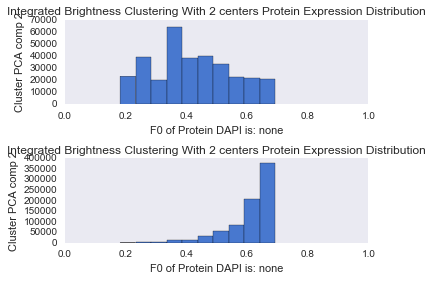

In [63]:
data = np.load('../../data/synapse_f1_features_log_normalized.npy')
X = data  # extract only the features
# X = X[:,inhib_excit_indices]
print 'data has shape: ', X.shape

# channel_inhib_excit = ['ex.pre','ex.pre','ex.pre','ex.pre','ex.pre','in.pre.small', 
#                'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre', 
#                'in.pre','in.post','in.post','in.post']

# set options and then cluster
num_clusters = 2
colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#11111', 'black', 'green', 'blue']
kmeans = cluster.MiniBatchKMeans(n_clusters = num_clusters, init="k-means++")
kmeans.fit(X)

# extract the data after fitting
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)


for i in range(0, len(channel)):#inhib_excit_indices)):
#     protein_to_plot = inhib_excit_indices[i]
    protein_to_plot = i
#     print protein_to_plot

    fig = plt.figure()
    plt.text(.5, .5, 'protein %s'%(channel[protein_to_plot]))

    
    ##### PLOT #####
    fig = plt.figure()
    for k, col in zip(range(num_clusters), colors):
        ax = fig.add_subplot(num_clusters, 1, k+1)

    #     lab = 'cluster '+ str(k+1) # label for this distribution
        my_members = k_means_labels == k # get indices of this current cluster membership
        data = X[my_members,protein_to_plot]
        
        ## line to get rid of data with expression 0?
        data = data[data!=0]
        
        binwidth = 0.5
        ax.hist(data)
        ax.grid(False)
        ax.legend(loc='upper left')
        ax.set_xlabel('F0 of Protein ' + channel[protein_to_plot] + ' is: ' + channeltype[i])
        ax.set_ylabel('Cluster PCA comp 2')
        ax.set_xlim([0, 1.0])
        ax.set_title('Integrated Brightness Clustering With ' + str(num_clusters) + ' centers Protein Expression Distribution')
        plt.tight_layout()

## F1 Discussion
5HT1A and DAPI visually separate with Vglut3